In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

In [2]:
tow = pd.read_excel('tow.xlsx')
tow.columns = map(str.lower, tow.columns)
tow.columns = tow.columns.str.replace(' ', '_')
tow.columns = tow.columns.str.replace('?', '')
faction_replace = {'Warriors of Chaos': 'W_Chaos', 'Tomb Kings of Khemri': 'Tomb_Kings', 'Kingdom of Bretonnia': 'Bretonnia', 'Ogre Kingdoms': 'Ogres', 'Wood Elf Realms': 'Wood_Elves', 'Dwarfen Mountain Holds': 'Dwarves', 'Orc and Goblin Tribes': 'O&G', 'Empire of Man': 'Empire', 'Beastmen Brayherds': 'Beastmen', 'High Elf Realms': 'High_Elves', 'Daemons of Chaos': 'D_Chaos'}
result_replace = {1:0.5, 2:1}
tow.replace({'player1_faction':faction_replace}, inplace=True)
tow.replace({'player2_faction':faction_replace}, inplace=True)
tow.replace({'player1_result': result_replace}, inplace=True)
tow.replace({'player2_result': result_replace}, inplace=True)

# Warhammer: The Old World
## A Statistical Analysis of Tournament Win Rates
### By: Jacob M. Lundeen

I was first introduced to Games Workshop's (GW) Warhammer: Fantasy Battles (WFB) back in the mid 1990's in Fairfax, Virginia. I was in the fifth or sixth grade and wondered by a GW store with my parents. I convinced them to take me in and managed to walk out with my first eight pack of skeleton warriors (Undead for life!). Over the next couple of years I would acquire a healthy collection of miniatures that was significantly boosted by my winning a White Dwarf survey contest and bringing home $5k worth of Tyranids, Dogs of War, Blood Bowl, and a others. As I grew up, I lost interest in WFB for various reasons as a lot of kids do. However, with WFB being reborn as Warhammer: The Old World (TOW) earlier this year, and me as an adult able to afford this hobby, I jumped back in and haven't looked back.

Since I've rediscovered TOW, I've wanted to combine TOW with one of my other passions, Data Science. With TOW only having returned earlier this year, the available data set is still immature. As we'll see there are many instances of incredible small sample sizes when we look at specific faction versus faction. But my hope is this will give an interesting look into where the game currently stands, where it might need to go, and lead to other interesting questions to ask and explore.

## The Data
The data I am using comes from the Woehammer website (woehammer.com). They compiled their dataset by scraping several tournament tracking websites such as Best Coast Pairings (bestcoastpairings.com). Tournaments use these websites to manage and track their results. I've already done the intial cleaning of the dataset, getting the column names correct and replacing the faction names with shorter names for ease of reading.

In [3]:
tow.shape

(2030, 31)

In [4]:
tow.head()

,pairing_id,round,player1_name,player2_name,player1_result,player2_result,player1_score,player2_score,event_name,event_date,...,points,rounds,ruleset,full_data,mirror_match,players,legacy_lists,allies,rule_of_3,faction_v_faction
0,405136,1,Ridvan Martinez,David Clarke,1.0,0.0,1770.0,901.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,N,N,12,Y,NaN,NaN,Wood Elf Realms
1,405155,1,Mike Summerfeldt,Russ Jeffery,0.0,1.0,450.0,1920.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Warriors of ChaosWood Elf Realms
2,405171,1,Brandon Deamer,Eddie Crampton,1.0,0.0,1745.0,1531.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Tomb Kings of KhemriHigh Elf Realms
3,405192,1,taylor hanson,Luka Pavicevic,0.0,1.0,867.0,1205.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Kingdom of BretonniaDwarfen Mountain Holds
4,405199,1,Eric Locke,Danny Stewart,0.0,1.0,815.0,1206.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,N,N,12,Y,NaN,NaN,Ogre Kingdoms


So we currently have 2020 entries and 31 variables. We are not interested in all of these variables, I'll primarily be looking at player1_result, player2_result, player1_faction, player2_faction, points, and ruleset. The dataset also has two columns, full_data and mirror_match, that will help us filter for the data we want. The former identifies any match where one or both of the players have missing data (name, result, faction) and the latter is if the same faction plays against itself which will be excluded from analysis.

In [5]:
tow = tow.query("`mirror_match` == 'N' & full_data == 'Y'")
tow.shape

(1616, 31)

With the initial filtering done, we stand at 1616 samples. However, each sample contains the data for both players. To be able to do any analysis, we need to transform the dataset so each sample pertains to a single player's (or for our focus faction's) result.

In [6]:
player1_db = tow[['player1_faction', 'player2_faction' ,'player1_result', 'points', 'rounds', 'ruleset', 'players']].rename(columns={"player1_faction": "player_faction", "player2_faction" : "opponent_faction", "player1_result" : "result"})
player2_db = tow[['player2_faction', 'player1_faction', 'player2_result', 'points', 'rounds', 'ruleset', 'players']].rename(columns={"player2_faction": "player_faction", "player1_faction" : "opponent_faction", "player2_result" : "result"})
player_db = pd.concat([player1_db, player2_db], ignore_index=True)
display(player_db)

,player_faction,opponent_faction,result,points,rounds,ruleset,players
0,W_Chaos,Wood_Elves,0.0,2000,3,v1.1,12
1,Tomb_Kings,High_Elves,1.0,2000,3,v1.1,12
2,Bretonnia,Dwarves,0.0,2000,3,v1.1,12
3,Ogres,Dwarves,1.0,2000,3,v1.1,12
4,Wood_Elves,Tomb_Kings,1.0,2000,3,v1.1,12
...,...,...,...,...,...,...,...
3227,High_Elves,Dark Elves,1.0,1250,3,v1.2,10
3228,Bretonnia,Skaven,0.0,1250,3,v1.2,10
3229,Tomb_Kings,Ogres,1.0,1250,3,v1.2,10
3230,O&G,D_Chaos,0.0,1250,3,v1.2,10


There we go, 3232 samples with 7 variables. The dataset is now ready for us to start diving into.

## Analysis
### Baseline
We will start with establishing a baseline from where we can compare the rest of the analyses. So we will look at the win rates for all factions regardless of point size, tournament length, etc. Also, ties will be counted as half a win.

In [7]:
tow_faction_wr = player_db.groupby(['player_faction'])['opponent_faction'].count().reset_index()
wins_db = player_db.query("result != 0.0").groupby(['player_faction'])['result'].sum().reset_index()
tow_faction_wr['wins'] = wins_db['result']
tow_faction_wr.rename(columns={'opponent_faction':'games_played'}, inplace=True)
tow_faction_wr['win_rate'] = tow_faction_wr['wins'] / tow_faction_wr['games_played']
tow_faction_wr['points'] = 'all'
tow_faction_wr = tow_faction_wr[list(('player_faction', 'points', 'games_played', 'wins', 'win_rate'))]
tow_faction_wr

,player_faction,points,games_played,wins,win_rate
0,Beastmen,all,163,85.0,0.521472
1,Bretonnia,all,378,206.0,0.544974
2,Chaos Dwarfs,all,59,29.0,0.491525
3,D_Chaos,all,89,42.0,0.471910
4,Dark Elves,all,137,63.0,0.459854
5,Dwarves,all,258,115.5,0.447674
6,Empire,all,240,92.0,0.383333
7,High_Elves,all,222,120.0,0.540541
8,Lizardmen,all,84,37.5,0.446429
9,O&G,all,320,164.0,0.512500


So what do we see here: four factions have less than one hundred games played and every faction has at least twenty-nine wins. Four factions have over three hundred games played. Of the sixteen factions, five have win rates outside the accepted "sweet spot" of 45-55%, all of which are under 45%.

### Win Rate by Points
Now that the baseline has been established, we can start to dive deeper into the data to see what we can find. The first dive is going to look at win rates when point sizes are accounted for. The first thing we do will determine the three most popular points sizes.

In [8]:
player_db.groupby(['points'])['player_faction'].count().sort_values(ascending=False).reset_index()

,points,player_faction
0,2000,1672
1,1500,836
2,1250,334
3,1999,128
4,1000,110
5,1750,106
6,2500,30
7,2250,10
8,500,6


We see the three most popular point sizes are 2000, 1500, and 1250. We will show the win rates from the three points values individually and then perform our statistical analysis afterward.

In [9]:
tow_points_wr = player_db.groupby(['player_faction', 'points'])['opponent_faction'].count().reset_index()
tow_points_wins = player_db.query("result != 0.0").groupby(['player_faction', 'points'])['result'].sum().reset_index()
tow_points_wr = tow_points_wr.merge(tow_points_wins, left_on=['player_faction', 'points'], right_on=['player_faction', 'points'], how='left')
tow_points_wr.rename(columns={'opponent_faction':'games_played', 'result':'wins'}, inplace=True)
tow_points_wr['win_rate'] = tow_points_wr['wins'] / tow_points_wr['games_played']
tow_points_wr = pd.concat([tow_points_wr, tow_faction_wr], ignore_index=True).sort_values(by=['player_faction', 'points']).dropna().reset_index(drop=True)
tow_points_wr['points'] = tow_points_wr['points'].astype(str)
tow_points_wr

,player_faction,points,games_played,wins,win_rate
0,Beastmen,1250,16,8.0,0.500000
1,Beastmen,1500,49,18.5,0.377551
2,Beastmen,1750,14,8.5,0.607143
3,Beastmen,1999,2,1.0,0.500000
4,Beastmen,2000,82,49.0,0.597561
...,...,...,...,...,...
110,Wood_Elves,1750,7,4.5,0.642857
111,Wood_Elves,1999,11,4.5,0.409091
112,Wood_Elves,2000,111,57.0,0.513514
113,Wood_Elves,2250,2,2.0,1.000000


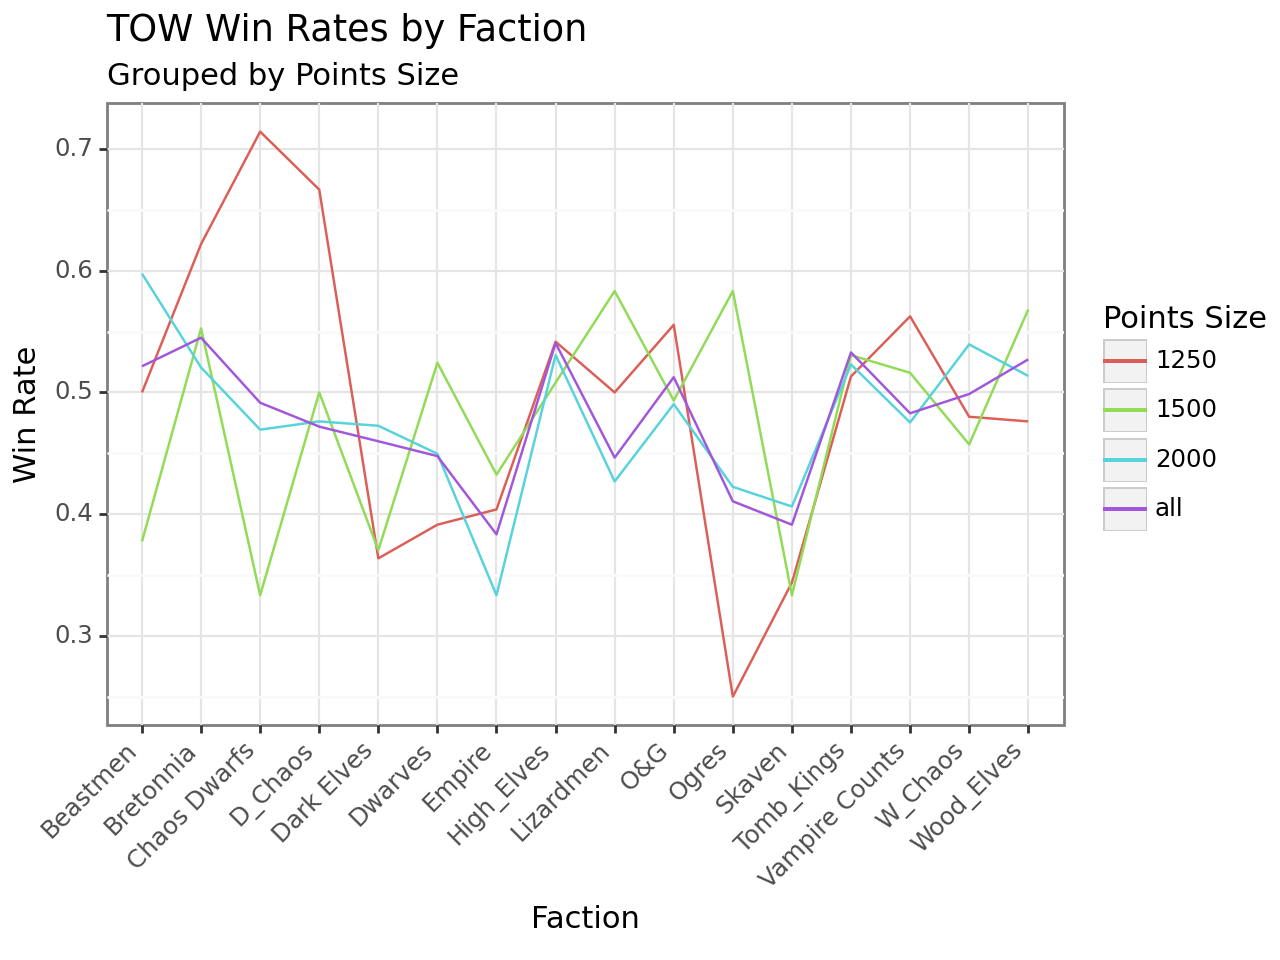

<Figure Size: (640 x 480)>

In [10]:
filter_list = ['all', '2000', '1500', '1250']
tow_plot = tow_points_wr.query("points == @filter_list")
(
    ggplot(tow_plot, aes(x='player_faction', y='win_rate', group='points', color='points'))
    + geom_line()
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1))
    + labs(title='TOW Win Rates by Faction', subtitle='Grouped by Points Size', x='Faction', y='Win Rate', color='Points Size')
)

In [11]:
import statsmodels.api as smf
tow_reg = pd.get_dummies(tow_plot, columns=['points', 'player_faction'], prefix='', prefix_sep='', dtype=float)
column_names = list(tow_reg.columns.values)
column_names.remove('games_played')
column_names.remove('wins')
column_names.remove('win_rate')

target = tow_reg['win_rate']
features = tow_reg[column_names]
features = smf.add_constant(features)

model = smf.OLS(target, features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     1.980
Date:                Thu, 06 Jun 2024   Prob (F-statistic):             0.0325
Time:                        19:52:57   Log-Likelihood:                 87.492
No. Observations:                  64   AIC:                            -137.0
Df Residuals:                      45   BIC:                            -95.97
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3674      0.007     52.452      0.000       0.353       0.381
1250               0.1024      0.016      6.396      0.000       0.070       0.135
1500               0.0887      0.016      5.536      0.000       0.056       0.121
2000               0.0876      0.016      5.469      0.000       0.055       0.120
all                0.0886      0.016      5.534      0.000       0.056       0.121
Beastmen           0.0399      0.036      1.121      0.268      -0.032       0.112
Bretonnia          0.1008      0.036      2.831      0.007       0.029       0.173
Chaos Dwarfs       0.0429      0.036      1.205      0.234      -0.029       0.115
D_Chaos            0.0695      0.036      1.951      0.057      -0.002       0.141
Dark Elves        -0.0426      0.036     -1.196      0.238      -0.114       0.029
Dwarves           -0.0060      0.036     -0.168      0.867      -0.078       0.066
Empire            -0.0710      0.036     -1.993      0.052      -0.143       0.001
High_Elves         0.0710      0.036      1.995      0.052      -0.001       0.143
Lizardmen          0.0299      0.036      0.841      0.405      -0.042       0.102
O&G                0.0537      0.036      1.509      0.138      -0.018       0.125
Ogres             -0.0426      0.036     -1.198      0.237      -0.114       0.029
Skaven            -0.0906      0.036     -2.543      0.014      -0.162      -0.019
Tomb_Kings         0.0657      0.036      1.845      0.072      -0.006       0.137
Vampire Counts     0.0500      0.036      1.404      0.167      -0.022       0.122
W_Chaos            0.0346      0.036      0.973      0.336      -0.037       0.106
Wood_Elves         0.0620      0.036      1.742      0.088      -0.010       0.134
==============================================================================
Omnibus:                        9.303   Durbin-Watson:                   2.640
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               17.473
Skew:                           0.334   Prob(JB):                     0.000161
Kurtosis:                       5.471   Cond. No.                     1.59e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.32e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""